In [124]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

### Load Data

In [125]:
# Load the data as numpy arrays
img_1 = pd.read_csv('./../data/feaSubEImg_1.csv', header=None).to_numpy()
img_2 = pd.read_csv('./../data/feaSubEImg_2.csv', header=None).to_numpy()
overt_1 = pd.read_csv('./../data/feaSubEOvert_1.csv', header=None).to_numpy()
overt_2 = pd.read_csv('./../data/feaSubEOvert_2.csv', header=None).to_numpy()

# Load sensors data
sensors_data = pd.read_csv('./../data/BCIsensor_xy.csv', header=None).to_numpy()

In [126]:
# Combine the features
img_X = np.hstack((img_1, img_2)).T
img_y = np.array([0] * img_1.shape[1] + [1] * img_2.shape[1])

overt_X = np.hstack((overt_1, overt_2)).T
overt_y = np.array([0] * overt_1.shape[1] + [1] * overt_2.shape[1])

# Get the x and y coordinates of the sensors
sensor_x = sensors_data[:, 0]
sensor_y = sensors_data[:, 1]

In [127]:
# Function to split the weights from the results
def split_weights(weights_vector):
    x_weights = weights_vector[:102]
    y_weights = weights_vector[102:]
    return x_weights, y_weights


### Stem plot of Signed SVM weights

In [128]:
def stem_plot_svm_weights(x_w, y_w, top_k=6, title= "Stem Plot of SVM Weights"):
    # Combine the weights
    weights = np.concatenate([x_w, y_w])
    indices = np.arange(len(weights))

    # Get top-k dominant weights (by absolute value)
    top_k_indices = np.argsort(np.abs(weights))[-top_k:][::-1]

    # Stem plot
    plt.figure(figsize=(10, 4))
    markerline, stemlines, baseline = plt.stem(indices, weights)
    plt.setp(stemlines, 'color', 'blue')
    plt.setp(markerline, 'color', 'blue')

    # Highlight top-k
    plt.scatter(top_k_indices, weights[top_k_indices], color='red', zorder=5, label='Top 6 Dominant')
    for i in top_k_indices:
        plt.text(i, weights[i], f"{i}", ha='center', va='bottom', fontsize=8, color='red')

    plt.axhline(0, color='black', linewidth=0.5)
    plt.xlabel("Feature Index")
    plt.ylabel("SVM Weight")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return top-k info
    return [(i, weights[i]) for i in top_k_indices]

### Brain Surface Weight visualization

In [129]:
def plot_weight_magnitudes_on_brain(x_w, y_w, sensor_x, sensor_y, title="SVM Weight Magnitudes"):
    # Get the absolute weights
    weights = np.sqrt(x_w**2 + y_w**2)

    # Grid for interpolation
    grid_x, grid_y = np.mgrid[
        sensor_x.min()-0.05:sensor_x.max()+0.05:200j, 
        sensor_y.min()-0.05:sensor_y.max()+0.05:200j
    ]
    
    # Interpolate the weights across the 2D grid
    grid_z = griddata(
        points=(sensor_x, sensor_y),
        values=np.abs(weights),
        xi=(grid_x, grid_y),
        method='cubic'
    )

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(
        grid_z.T,
        extent=(sensor_x.min(), sensor_x.max(), sensor_y.min(), sensor_y.max()),
        origin='lower',
        cmap='jet',
        aspect='auto'
    )
    plt.colorbar(label="|Weight| Magnitude")
    plt.scatter(sensor_x, sensor_y, c='k', s=10)  # Electrode positions
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Two level Cross-validation with weights

In [130]:
# Inner cross-validation
def inner_cv(X_train, y_train, C_values=[0.01, 1, 100, 10000], n_splits=5):
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    val_accuracies = {C: [] for C in C_values}

    # Iterate through each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the data for the fold
        X_inner_train, X_val = X_train[train_idx], X_train[val_idx]
        y_inner_train, y_val = y_train[train_idx], y_train[val_idx]

        # For each fold, train and evaluate the model for each C value
        for C in C_values:
            clf = SVC(kernel='linear', C=C)
            clf.fit(X_inner_train, y_inner_train)
            y_val_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_val_pred)
            val_accuracies[C].append(acc)

    avg_acc = {C: np.mean(accs) for C, accs in val_accuracies.items()}
    best_C = max(avg_acc, key=avg_acc.get)
    return best_C, val_accuracies

In [131]:
def two_level_cross_validation(X, y, outer_splits=6, inner_splits=5, C_values=[0.01, 1, 100, 10000]):
    # Split the data into 6 folds
    outer_skf = StratifiedKFold(n_splits=outer_splits, shuffle=True)

    accuracies = []
    best_Cs = []
    y_true_all = []
    y_pred_all = []
    decision_scores_all = []
    weights_all = []

    # Iterate through each outer fold
    for fold_idx, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):
        # Get the training and test data for the outer fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner CV to find best C
        best_C, _ = inner_cv(X_train, y_train, C_values=C_values, n_splits=inner_splits)
        best_Cs.append(best_C)

        # Train final model on all outer training data using best C
        model = SVC(kernel='linear', C=best_C)
        model.fit(X_train, y_train)
        
        # Store weights (1D array of length 204)
        weights_all.append(model.coef_.flatten())

        # Evaluate on outer test fold
        y_pred = model.predict(X_test)
        decision_scores = model.decision_function(X_test)
        acc = accuracy_score(y_test, y_pred)

        # Store results
        accuracies.append(acc)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        decision_scores_all.extend(decision_scores)

        print(f"[Fold {fold_idx+1}] Accuracy: {acc:.2f}, Best C: {best_C}")

    return {
        'accuracies': accuracies,
        'best_Cs': best_Cs,
        'y_true_all': np.array(y_true_all),
        'y_pred_all': np.array(y_pred_all),
        'decision_scores_all': np.array(decision_scores_all),
        'weights_all': np.array(weights_all)
    }

## Weights and Stem plots

In [132]:
C_values = [
    0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316,
    0.1, 0.316, 1.0, 3.16, 10.0, 31.6, 100.0
]

### Overt Data First fold

In [133]:
# Perform two-level cross-validation
results_overt = two_level_cross_validation(overt_X, overt_y, C_values=C_values)

# Get the weights from the first fold and separate them
w1_overt = results_overt['weights_all'][0]
x_w_overt, y_w_overt = split_weights(w1_overt)

[Fold 1] Accuracy: 0.93, Best C: 0.0001
[Fold 2] Accuracy: 0.95, Best C: 0.0001
[Fold 3] Accuracy: 0.93, Best C: 0.0001
[Fold 4] Accuracy: 0.97, Best C: 0.0001
[Fold 5] Accuracy: 0.97, Best C: 0.0001
[Fold 6] Accuracy: 0.88, Best C: 0.0001


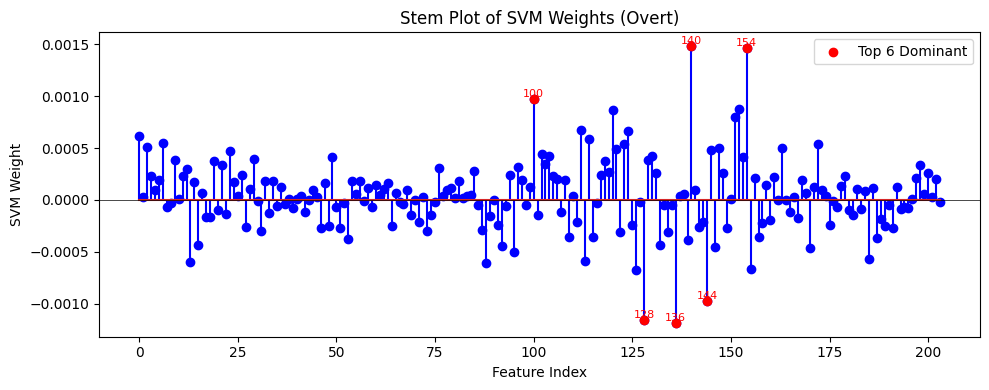

Feature 140: Weight 0.0015
Feature 154: Weight 0.0015
Feature 136: Weight -0.0012
Feature 128: Weight -0.0012
Feature 144: Weight -0.0010
Feature 100: Weight 0.0010


In [134]:
top6_weights_overt = stem_plot_svm_weights(x_w_overt, y_w_overt, title= "Stem Plot of SVM Weights (Overt)")
for i, w in top6_weights_overt:
    print(f"Feature {i}: Weight {w:.4f}")

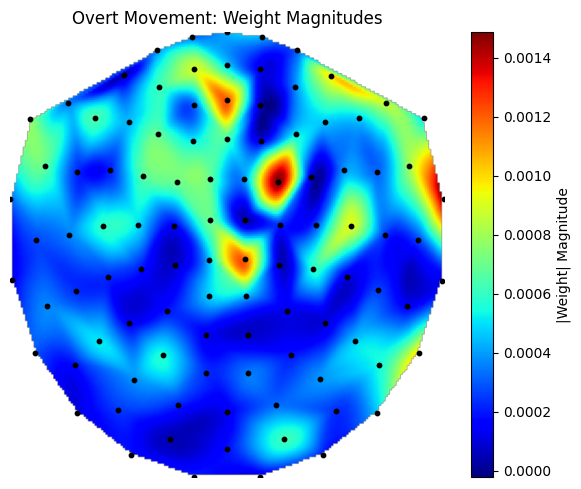

In [135]:
# Plot the weight magnitudes on the brain
plot_weight_magnitudes_on_brain(x_w_overt, y_w_overt, sensor_x, sensor_y, title="Overt Movement: Weight Magnitudes")

### Imagined Data first fold

In [136]:
# Perform two-level cross-validation
results_img = two_level_cross_validation(img_X, img_y, C_values=C_values)

# Get the weights from the first fold and separate them
w1_img = results_img['weights_all'][0]
x_w_img, y_w_img = split_weights(w1_img)

[Fold 1] Accuracy: 0.85, Best C: 0.0001
[Fold 2] Accuracy: 0.93, Best C: 0.0001
[Fold 3] Accuracy: 0.93, Best C: 0.0001
[Fold 4] Accuracy: 0.85, Best C: 0.0001
[Fold 5] Accuracy: 0.85, Best C: 0.0001
[Fold 6] Accuracy: 0.90, Best C: 0.0001


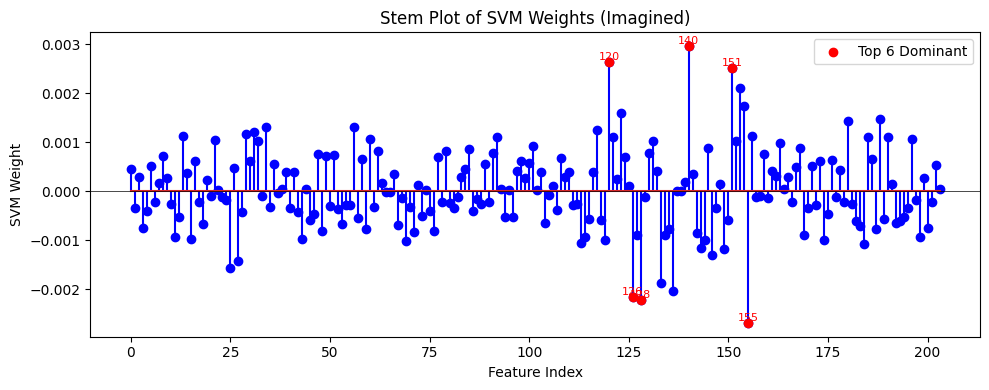

Feature 140: Weight 0.0030
Feature 155: Weight -0.0027
Feature 120: Weight 0.0026
Feature 151: Weight 0.0025
Feature 128: Weight -0.0022
Feature 126: Weight -0.0022


In [137]:
top6_weights_img = stem_plot_svm_weights(x_w_img, y_w_img, title="Stem Plot of SVM Weights (Imagined)")
for i, w in top6_weights_img:
    print(f"Feature {i}: Weight {w:.4f}")

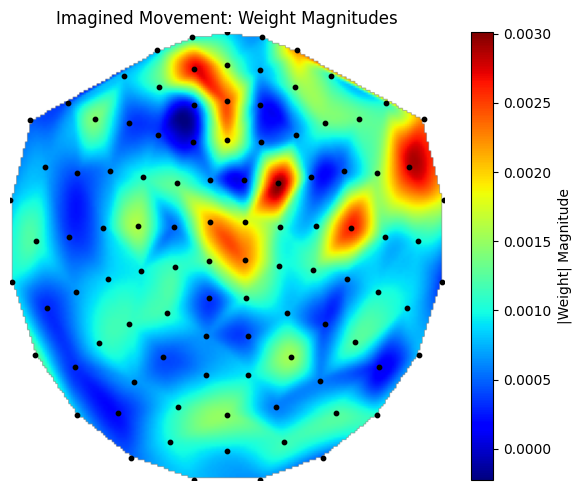

In [138]:
plot_weight_magnitudes_on_brain(x_w_img, y_w_img, sensor_x, sensor_y, title="Imagined Movement: Weight Magnitudes")